In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 

from functions import join_stocks_crypto, generate_rand_portfolios

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data.csv', index_col='Date')

joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left') #mode - either do left with crypto and fill NA for stocks or do left on stocks and leave out some dates for cryptos
joined_df.index = pd.to_datetime(joined_df.index)

In [ ]:
# df_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
# df_returns.to_csv('data_for_R/dataframe_returns.csv')

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [4]:
tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)

In [5]:
def run_simulation(portfolio_dict:dict, returns_for_portfolio:pd.DataFrame, n_sims=100, t=100, distribution_model='multivar_norm', plot=False, initialPortfolio=100):
    mean_returns = returns_for_portfolio.mean()
    cov_matrix = returns_for_portfolio.cov()

    weights = [v for _, v in portfolio_dict.items()]

    meanM = np.tile(mean_returns, (t, 1))  # Shape: (T, n_assets)

    portfolio_sims = np.zeros((t, n_sims))

    L = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition outside the loop

    for sim in range(n_sims):
        Z = np.random.normal(size=(t, len(portfolio_dict)))  # Shape: (T, n_assets)
        daily_returns = meanM + Z @ L.T  # Shape: (T, n_assets)

        portfolio_returns = daily_returns @ weights  # Shape: (T,)
        portfolio_sims[:, sim] = np.cumprod(1 + portfolio_returns) * initialPortfolio

    if plot:
        plt.plot(portfolio_sims)
        plt.title("Monte Carlo Simulated Portfolio Paths")
        plt.xlabel("Days")
        plt.ylabel("Portfolio Value")
        plt.show()

    return portfolio_sims

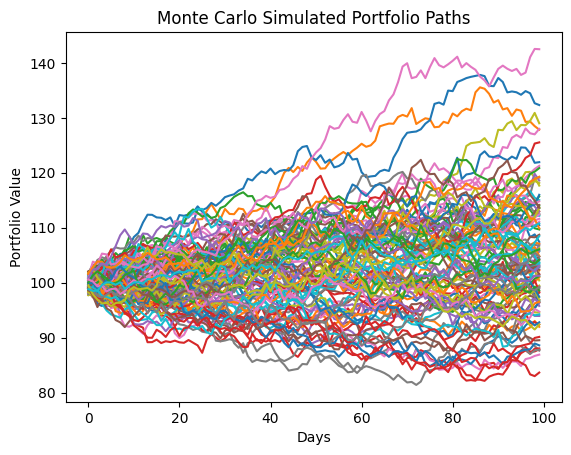

array([[101.25978567,  98.45611296, 100.99236317, ...,  99.31589814,
         99.51151843,  98.82550406],
       [101.24854088,  98.71956161, 101.87984772, ...,  98.52286485,
         97.89027237,  98.51095727],
       [100.45895096, 100.55738145, 102.16874791, ...,  97.60318741,
         96.90390467,  98.51585623],
       ...,
       [108.27611812,  91.85845753, 111.65320728, ...,  98.96045492,
         92.20738351, 109.57108601],
       [108.78454602,  93.03518418, 112.97174282, ...,  98.56802188,
         91.48081614, 110.36457933],
       [107.42998034,  91.9567084 , 113.55780981, ...,  99.24415254,
         92.38249987, 110.7942589 ]], shape=(100, 100))

In [6]:
returns_all = df_all_stocks.pct_change()
portfolio = random_portfolios['portfolio_0']

returns_portfolio = returns_all[list(portfolio.keys())]


run_simulation(portfolio, returns_portfolio, n_sims=100, t=100, distribution_model='multivar_norm', plot=True)